In [1]:
import numpy as np
import matplotlib.pylab as plt
np.set_printoptions(precision=2)
import scipy.io as sio

# Cvicna data
Nejprve si nagenerujeme (nebo nacteme) data podle modelu
$$
D=AX^T+E
$$
kde $A$ je matice zdrojovych obrazku (ulozenych vektorizovane ve sloupcich), $X$ je matice vah techto zdroju, $E_{i,j}\sim N(0,\sigma)$. 

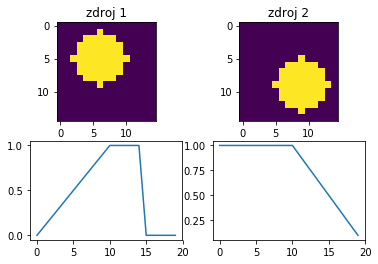

In [3]:
strana = 15 ### strana zdrojoveho obrazku
p = np.power(strana,2)
n = 20 ### pocet mereni

er = 2 # simulovany pocet zdroju
if 1:
    D = sio.loadmat("cvicna_data.mat")["D"]
    A_true = sio.loadmat("cvicna_data.mat")["A"]
    X_true = sio.loadmat("cvicna_data.mat")["X"]
else:
    ### muzete si zkusit nagenerovat sami
    A_true = np.zeros(p,er)
    X_true = np.zeros(n,er)
    D = A@X.T
    
    
plt.figure()
r = 2
for i in range(1,r+1):
    plt.subplot(2,r,i)
    plt.imshow(A_true[:,i-1].reshape(strana,strana),interpolation='none')
    plt.title('zdroj %s'%i)
    plt.subplot(2,r,r+i)
    plt.plot(X_true[:,i-1])

# Non-negative matrix factorization
My si vyzkousime verzi (Lee and Seung, Algorithms for non-negative matrix factorization, NIPS 2001), ktera alternuje nasledujici updatovaci pravidla:
\begin{align}
X^{T}\leftarrow & X^{T}\circ\left(\left(A^{T}D\right)\oslash\left(A^{T}AX^{T}\right)\right)\\
A\leftarrow & A\circ\left(\left(DX\right)\oslash\left(AX^{T}X\right)\right)
\end{align}
kde $\circ$ je nasobeni "po prvcich" a $\oslash$ je deleni
"po prvcich".

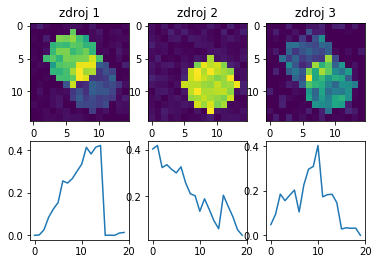

In [9]:
r = 3 ### nastavime predpokladany pocet zdroju

# nastavime nejake inicializacni hodnoty pro A a X
A = np.random.random(size=(p,r))
X = np.random.random(size=(n,r))

# vytvorte for-cyklus, ktery 100x vykona updatovaci pravidla NMF
for i in range(100):
    XT = X.T * ((A.T@D) / (A.T@A@X.T))
    X = XT.T
    A = A * ((D@X) / (A@X.T@X))
    
plt.figure()
for i in range(1,r+1):
    plt.subplot(2,r,i)
    plt.imshow(A[:,i-1].reshape(strana,strana),interpolation='none')
    plt.title('zdroj %s'%i)
    plt.subplot(2,r,r+i)
    plt.plot(X[:,i-1])

# Variacni PCA
Pripomenme soustavu implicitnich rovnic odvozenych na prednasce, kde jsme odvodili tvarovaci parametry aposteriornich rozdeleni 
\begin{align}
\tilde{f}(\omega|D,r)&=G_{\omega}(\vartheta,\rho)\\
\tilde{f}(A|D,r)&=N_{A}(\mu_{A},I_{p}\otimes\Sigma_{A})\\
\tilde{f}(X|D,r)&=N_{X}(\mu_{X},I_{n}\otimes\Sigma_{X})
\end{align}
jako
\begin{align}
\vartheta&= \vartheta_{0}+\frac{np}{2}\\
\rho&= \rho_{0}+\frac{1}{2}\text{tr}\left(DD^{T}-\widehat{A}\widehat{X}^{T}D^{T}-D\widehat{X}\widehat{A}^{T}\right)+\frac{1}{2}\text{tr}\left(\widehat{A^{T}A}\widehat{X^{T}X}\right)\\
\Sigma_{A}&=\left(\widehat{\omega}\widehat{X^{T}X}+I_{r}\right)^{-1}\\
\mu_{A}&=\widehat{\omega}D\widehat{X}\Sigma_{A}\\
\Sigma_{X}&=\left(\widehat{\omega}\widehat{A^{T}A}+I_{r}\right)^{-1}\\
\mu_{X}&=\widehat{\omega}D^{T}\widehat{A}\Sigma_{X}.
\end{align}

Pripomenme, ze moment gamma rozdeleni $G_\omega(\vartheta,\rho)$ je
$$
\widehat{\omega} = \frac{\vartheta}{\rho}
$$
a momenty maticoveho normalniho rozdeleni $N_B(\mu_B,\Sigma_p\otimes \Sigma_n)$ jsou
\begin{align}
\widehat{B} &= \mu_B\\
\widehat{B^T B} &= \mu_B^T \mu_B + \text{tr}(\Sigma_p)\Sigma_n.
\end{align}

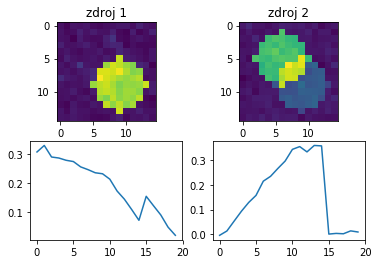

In [13]:
r = 2 ### nastavime predpokladany pocet zdroju

# apriorno
theta0 = 1e-10
rho0 = 1e-10

# nastavime nejake inicializacni hodnoty pro A a X
A_hat = np.random.random(size=(p,r))
#A_hat = np.full((p,r),1)

#X_hat = np.random.random(size=(n,r))

X_hat = np.full((n,r),1)
#hX = np.random.rand(n,r)
XtX_hat = np.eye(r)
omega_hat = 1


for i in range(0,100):
    
    # spocitame tvarovaci parametry a momenty A
    sigma_A = np.linalg.inv(omega_hat*XtX_hat + np.identity(r))
    mu_A = omega_hat*D@X_hat@sigma_A
    AtA_hat = mu_A.T@mu_A + np.trace(np.identity(p))*sigma_A
    A_hat = mu_A
    
    # spocitame tvarovaci parametry a momenty X
    sigma_X = np.linalg.inv(omega_hat*AtA_hat + np.identity(r))
    mu_X = omega_hat*D.T@A_hat@sigma_X
    XtX_hat = mu_X.T@mu_X + np.trace(np.identity(n))*sigma_X
    X_hat = mu_X
    
    # spocitame tvarovaci parametry a moment omega
    theta = theta0 + n*p / 2
    rho = rho0 + 0.5*np.trace(D@D.T - A_hat@X_hat.T@D.T - D@X_hat@A_hat.T) + 0.5*np.trace(AtA_hat@XtX_hat)
    omega_hat = theta/rho
    
    
    
plt.figure()
for i in range(1,r+1):
    plt.subplot(2,r,i)
    plt.imshow(A_hat[:,i-1].reshape(strana,strana),interpolation='none')
    plt.title('zdroj %s'%i)
    plt.subplot(2,r,r+i)
    plt.plot(X_hat[:,i-1])




# Variacni PCA s odhadem poctu komponent
Pripomenme soustavu implicitnich rovnic odvozenych na prednasce, kde jsme odvodili tvarovaci parametry aposteriornich rozdeleni
\begin{align}
\tilde{f}(\omega|D,r)&=G_{\omega}(\vartheta,\rho),\\
\tilde{f}(X|D,r)&=N_{X}(\mu_{X},I_{n}\otimes\Sigma_{X}),\\
\tilde{f}(A|D,r)&=N_{A}(\mu_{A},I_{p}\otimes\Sigma_{A}),\\
\tilde{f}(v_{k}|D,r)&=G_{v_{k}}(\alpha_{k},\beta_{k}),
\end{align}
s tvarovacimi parametry
\begin{align}
\vartheta= & \vartheta_{0}+\frac{np}{2},\\
\rho= & \rho_{0}+\frac{1}{2}\text{tr}\left(DD^{T}-\widehat{A}\widehat{X}^{T}D^{T}-D\widehat{X}\widehat{A}^{T}\right)+\frac{1}{2}\text{tr}\left(\widehat{A^{T}A}\widehat{X^{T}X}\right),\\
\Sigma_{X}=&\left(\widehat{\omega}\widehat{A^{T}A}+I_{r}\right)^{-1},\\ 
\mu_{X}=&\widehat{\omega}D^{T}\widehat{A}\Sigma_{X},\\
\Sigma_{A}=&\left(\widehat{\omega}\widehat{X^{T}X}+\text{diag}(\widehat{\mathbf{v}})\right)^{-1},\\
\mu_{A}=&\widehat{\omega}D\widehat{X}\Sigma_{A},\\
\alpha_{k}=&\alpha_{0}+\frac{p}{2},\\
\beta_{k}=&\beta_{0}+\frac{1}{2}\left(\widehat{A^{T}A}\right)_{k,k},
\end{align}

Pripomenme, ze moment gamma rozdeleni $G_\omega(\vartheta,\rho)$ je
$$
\widehat{\omega} = \frac{\vartheta}{\rho}
$$
a momenty maticoveho normalniho rozdeleni $N_B(\mu_B,\Sigma_p\otimes \Sigma_n)$ jsou
\begin{align}
\widehat{B} &= \mu_B\\
\widehat{B^T B} &= \mu_B^T \mu_B + \text{tr}(\Sigma_p)\Sigma_n.
\end{align}

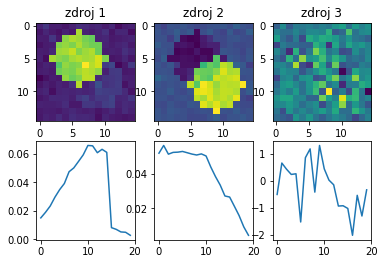

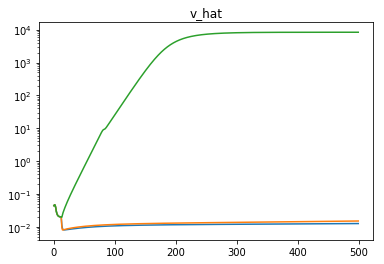

In [39]:
r = 3 ### nastavime predpokladany pocet zdroju

# apriorno
theta0 = 1e-10
rho0 = 1e-10
alpha0 = 1e-10
beta0 = 1e-10

# nastavime nejake inicializacni hodnoty pro A a X
A_hat = np.random.random(size=(p,r))
X_hat = np.full((n,r),1)
#hX = np.random.rand(n,r)
XtX_hat = np.eye(r)
omega_hat = 1
v_hat = np.ones(r)

n_iter = 500
hist_v_hat = np.ones((n_iter,r))

for i in range(0,n_iter):
    
    # spocitame tvarovaci parametry a momenty A
    sigma_A = np.linalg.inv(omega_hat*XtX_hat + np.diag(v_hat))
    mu_A = omega_hat*D@X_hat@sigma_A
    AtA_hat = mu_A.T@mu_A + np.trace(np.identity(p))*sigma_A
    A_hat = mu_A

    
    # spocitame tvarovaci parametry a moment vektoru v
    alpha_k = alpha0 + p/2
    beta_k = beta0*np.ones(shape=(AtA_hat.shape[0],)) + 0.5*np.diag(AtA_hat)
    v_hat = alpha_k / beta_k
    hist_v_hat[i] = v_hat
    #print("v_hat =", v_hat)
    
    # spocitame tvarovaci parametry a momenty X
    sigma_X = np.linalg.inv(omega_hat*AtA_hat + np.identity(r))
    mu_X = omega_hat*D.T@A_hat@sigma_X
    XtX_hat = mu_X.T@mu_X + np.trace(np.identity(n))*sigma_X
    X_hat = mu_X

        
    # spocitame tvarovaci parametry a moment omega
    theta = theta0 + n*p / 2
    rho = rho0 + 0.5*np.trace(D@D.T - A_hat@X_hat.T@D.T - D@X_hat@A_hat.T) + 0.5*np.trace(AtA_hat@XtX_hat)
    omega_hat = theta/rho
    
    ### kdo to ma: vytvorte graf s vyvojem hodnot vektoru v
    
    
plt.figure()
for i in range(1,r+1):
    plt.subplot(2,r,i)
    plt.imshow(A_hat[:,i-1].reshape(strana,strana),interpolation='none')
    plt.title('zdroj %s'%i)
    plt.subplot(2,r,r+i)
    plt.plot(X_hat[:,i-1])

plt.figure()
plt.plot(range(n_iter), hist_v_hat[:,0].flatten())
plt.title("v_hat")
plt.plot(range(n_iter), hist_v_hat[:,1].flatten())
plt.plot(range(n_iter), hist_v_hat[:,2].flatten())
plt.yscale("log", nonposy='clip')
